In [1]:
# example of defining a u-net encoder-decoder generator model
from __future__ import print_function
import os
import random
from random import randint
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
plt.style.use("grayscale")
%matplotlib inline
#%matplotlib notebook
import time

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from skimage import color

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.losses import mean_absolute_error,binary_crossentropy
import keras.backend as K

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

from keras.applications.vgg19 import VGG19
from keras.models import Model

from functions import *

Using TensorFlow backend.


In [2]:
def trainOnce(train_crops,iters,batch_size,weight_name,dir_name,loss_fact=0.5,loss_weights=[1,100],to_load=False,weight_name_saved=''):
    t_image_shape = (256,256,1);c_image_shape = (256,256,3)
    K.clear_session()
    
    d_model = define_discriminator(t_image_shape, c_image_shape)
    g_model = define_generator(t_image_shape)
    if to_load:
        g_model.load_weights(dir_name+'/g_model_' + weight_name_saved + '.h5')
        d_model.load_weights(dir_name+'/d_model_' + weight_name_saved + '.h5')
        
    gan_model = define_gan(g_model, d_model, t_image_shape, loss_fact=loss_fact, loss_weights=loss_weights)
    loss = train(d_model, g_model, gan_model, train_crops, iters, batch_size, weight_name=weight_name, dir_name=dir_name)
    save(loss, dir_name+'/loss__'+weight_name)

### Load Data

In [3]:
im_width = 640; im_height = 512
border = 5
path_train = '../../../data/FLIR/training/Calib_cut/'
# path_train = '/home/nvs/Documents/DB/FLIR/Calib/Sample2/'
#path_train = '/home/nadav.shalev/Desktop/Calib/'
X,Y = get_data(path_train, im_height, im_width)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=16/1040,random_state=2019)

/opt/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


### Prepare Model

In [114]:
batch_size = 8
dir_name = 'monday_schedualer_9.12'
weight_name = '0.02vgg_(1,1000)w_60e3iter_8b'
data_gen_args = dict(horizontal_flip=True)
train_crops = create_augment(X_train, 
               y_train, 
               dict_augments=data_gen_args, 
               batch_size=batch_size, 
               shuffle=True, 
               rand_crop=True, 
               seed=1234)
plot_crops = create_augment(X_train, 
               y_train, 
               dict_augments=data_gen_args, 
               batch_size=1, 
               shuffle=False, 
               rand_crop=False)
t_image_shape = (256,256,1);c_image_shape = (256,256,3)
d_model = define_discriminator(t_image_shape, c_image_shape)
g_model = define_generator(t_image_shape)
gan_model = define_gan(g_model, d_model, t_image_shape)


### load model

In [115]:
g_model.load_weights(dir_name+'/g_model_' + weight_name + '.h5')
# d_model.load_weights(dir_name+'/d_model_' + weight_name + '.h5')

### plot

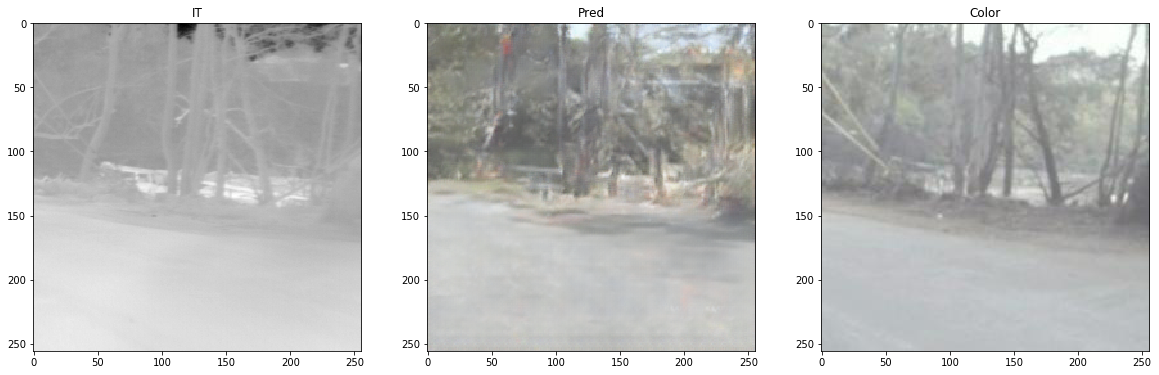

In [28]:
xi = plot_sample(plot_crops, g_model)

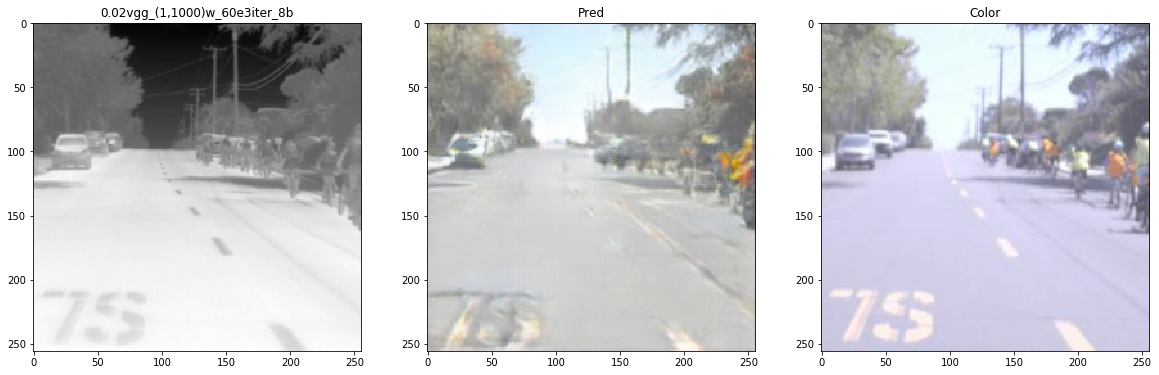

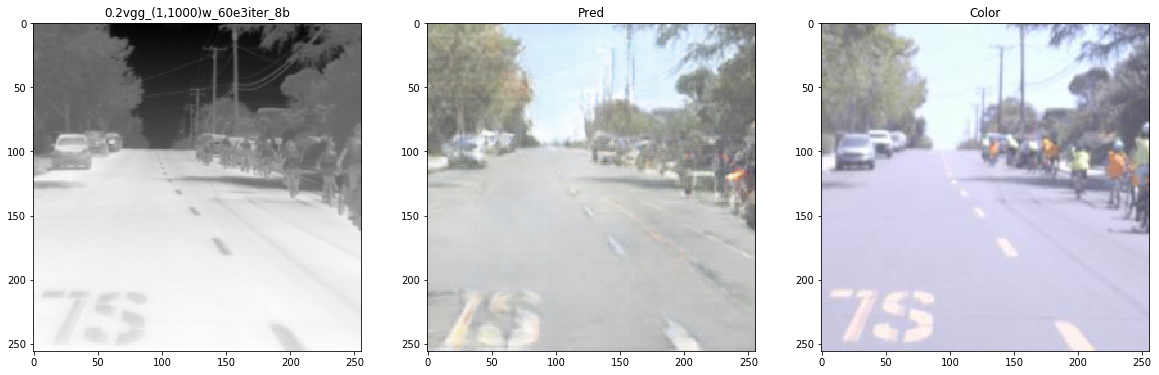

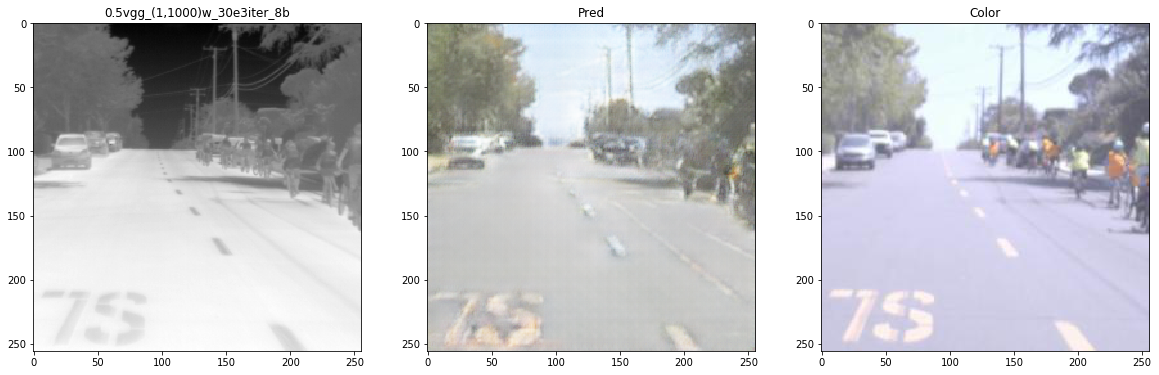

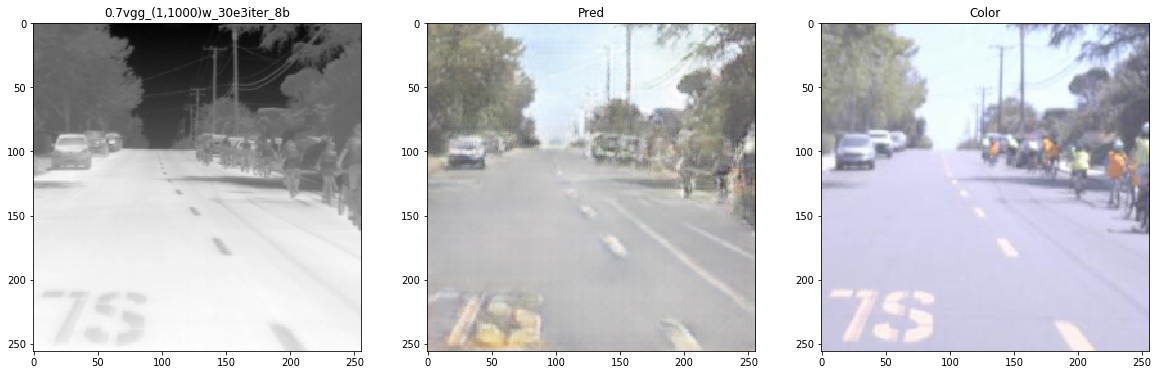

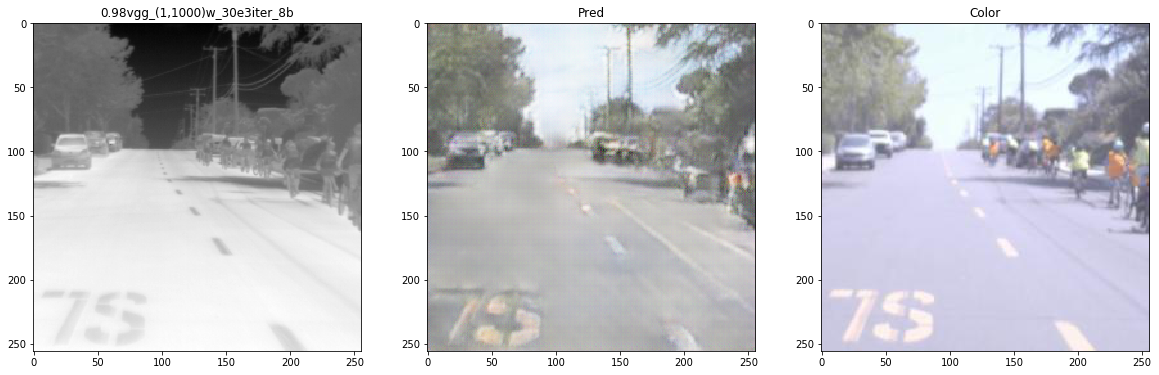

In [25]:
dir_name = 'monday_schedualer_9.12'
g_names = ['0.02vgg_(1,1000)w_60e3iter_8b','0.2vgg_(1,1000)w_60e3iter_8b','0.5vgg_(1,1000)w_30e3iter_8b','0.7vgg_(1,1000)w_30e3iter_8b','0.98vgg_(1,1000)w_30e3iter_8b']
plot_compare(g_names, dir_name, g_model, plot_crops)

### loss

Text(0.5, 1.0, 'Pred')

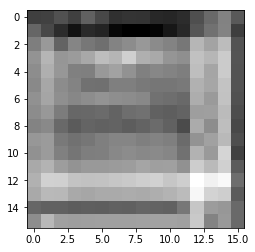

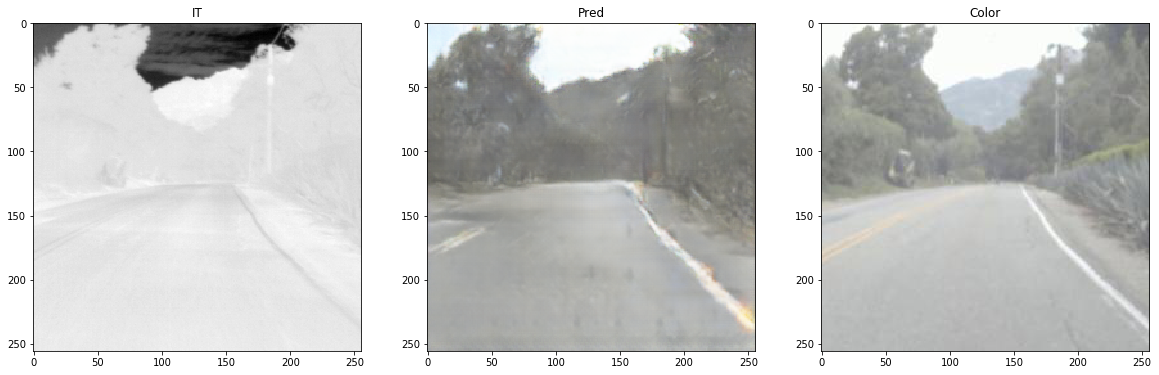

In [119]:
x, y = next(plot_crops)
# x2, y2 = next(plot_crops)
# xK = K.constant(x)
# yK= K.constant(y)
# x2, y2 = next(plot_crops)
# xK2 = K.constant(x2)
# yK2 = K.constant(y2)

# # predict
# yR = K.constant(g_model.predict(x))
yPred = g_model.predict(x);
rR = d_model.predict([np.ones((1,256,256,1)),yPred]).squeeze()
plt.imshow(rR)
# ssimTF = ssim_tf(ssim_fact=1)
# vggloss = vgg_obj(vgg_fact=1)

# # loss = ssimTF(yR,yK)
# # loss = vggloss(yR,yK)
# loss = mean_absolute_error(yK2,yK)
# # loss = binary_crossentropy(yR,yK)
# loss = K.eval(loss).squeeze()

# loss_once = np.sum(np.sum(loss, axis=-1), axis=-1)/loss.size
# print(loss_once)
# pltLoss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(x.squeeze())
ax[0].set_title('IT')

ax[2].imshow(y.squeeze())
ax[2].set_title('Color')

ax[1].imshow(yPred.squeeze())
ax[1].set_title('Pred')

In [113]:
np.min(rR)

1.0

# Train

In [28]:
scedual_trainings(batch_size, dir_name)

0, d_real[0.388] d_fake[0.643] g_total[49.348] g_cross[1.603] g_loss[0.477] 12.659[sec]
best loss model saved!
model saved...
1, d_real[0.868] d_fake[0.691] g_total[56.035] g_cross[1.625] g_loss[0.544] 4.489[sec]
2, d_real[0.653] d_fake[0.482] g_total[58.673] g_cross[1.822] g_loss[0.569] 4.609[sec]
3, d_real[0.429] d_fake[0.315] g_total[51.541] g_cross[1.840] g_loss[0.497] 5.858[sec]
4, d_real[0.460] d_fake[0.321] g_total[41.883] g_cross[1.666] g_loss[0.402] 5.799[sec]
5, d_real[0.222] d_fake[0.234] g_total[50.015] g_cross[2.028] g_loss[0.480] 5.802[sec]
6, d_real[0.125] d_fake[0.356] g_total[45.359] g_cross[2.510] g_loss[0.428] 5.779[sec]
7, d_real[0.166] d_fake[0.366] g_total[53.452] g_cross[2.774] g_loss[0.507] 5.785[sec]
8, d_real[0.152] d_fake[0.548] g_total[50.448] g_cross[2.354] g_loss[0.481] 5.923[sec]
9, d_real[0.065] d_fake[0.426] g_total[46.824] g_cross[2.734] g_loss[0.441] 6.225[sec]
0, d_real[0.541] d_fake[0.728] g_total[56.117] g_cross[2.741] g_loss[0.534] 11.075[sec]
bes

In [ ]:
# trainOnce(train_crops,
#               iters=30000,
#               batch_size=batch_size,
#               weight_name='0.02vgg_(1,1000)w_60e3iter_8b',
#               dir_name=dir_name,
#               loss_fact=0.02,
#               loss_weights=[1,1000],
#               to_load=True,
#               weight_name_saved='0.02vgg_(1,1000)w_30e3iter_8b')
trainOnce(train_crops,
              iters=2000,
              batch_size=batch_size,
              weight_name='0.2vgg_(1,1000)w_60e3iter_8b',
              dir_name=dir_name,
              loss_fact=0.2,
              loss_weights=[1,1000],
              to_load=True,
              weight_name_saved='0.02vgg_(1,1000)w_60e3iter_8b')
trainOnce(train_crops,
              iters=30000,
              batch_size=batch_size,
              weight_name='0.5vgg_(1,1000)w_60e3iter_8b',
              dir_name=dir_name,
              loss_fact=0.5,
              loss_weights=[1,1000],
              to_load=True,
              weight_name_saved='0.02vgg_(1,1000)w_30e3iter_8b')
trainOnce(train_crops,
              iters=30000,
              batch_size=batch_size,
              weight_name='0.98vgg_(1,1000)w_60e3iter_8b',
              dir_name=dir_name,
              loss_fact=0.98,
              loss_weights=[1,1000],
              to_load=True,
              weight_name_saved='0.02vgg_(1,1000)w_30e3iter_8b')
trainOnce(train_crops,
              iters=30000,
              batch_size=batch_size,
              weight_name='0.7vgg_(1,1000)w_60e3iter_8b',
              dir_name=dir_name,
              loss_fact=0.7,
              loss_weights=[1,1000],
              to_load=True,
              weight_name_saved='0.02vgg_(1,1000)w_30e3iter_8b')

0, d_real[0.000] d_fake[0.675] g_total[77.842] g_cross[4.201] g_loss[0.074] 8.645[sec]
best loss model saved!
model saved...
1, d_real[0.018] d_fake[0.001] g_total[69.922] g_cross[7.071] g_loss[0.063] 0.506[sec]
2, d_real[0.049] d_fake[0.000] g_total[70.769] g_cross[7.769] g_loss[0.063] 0.505[sec]
3, d_real[0.028] d_fake[0.007] g_total[84.724] g_cross[4.996] g_loss[0.080] 0.500[sec]
4, d_real[0.000] d_fake[0.004] g_total[75.032] g_cross[6.376] g_loss[0.069] 0.497[sec]
5, d_real[0.032] d_fake[0.006] g_total[79.242] g_cross[5.103] g_loss[0.074] 0.510[sec]
6, d_real[0.015] d_fake[0.003] g_total[74.757] g_cross[5.451] g_loss[0.069] 0.507[sec]
7, d_real[0.000] d_fake[0.001] g_total[88.640] g_cross[6.447] g_loss[0.082] 0.508[sec]
8, d_real[0.017] d_fake[0.006] g_total[82.454] g_cross[5.436] g_loss[0.077] 0.513[sec]
9, d_real[0.000] d_fake[0.014] g_total[92.675] g_cross[5.377] g_loss[0.087] 0.512[sec]
10, d_real[0.000] d_fake[0.049] g_total[70.481] g_cross[6.352] g_loss[0.064] 0.506[sec]
best

93, d_real[0.570] d_fake[0.033] g_total[74.058] g_cross[2.705] g_loss[0.071] 0.486[sec]
94, d_real[0.001] d_fake[0.075] g_total[67.341] g_cross[4.054] g_loss[0.063] 0.482[sec]
95, d_real[0.001] d_fake[0.038] g_total[68.219] g_cross[4.729] g_loss[0.063] 0.492[sec]
96, d_real[0.002] d_fake[0.057] g_total[58.517] g_cross[4.514] g_loss[0.054] 0.487[sec]
97, d_real[0.012] d_fake[0.281] g_total[69.352] g_cross[7.415] g_loss[0.062] 0.481[sec]
98, d_real[0.002] d_fake[0.004] g_total[73.855] g_cross[7.065] g_loss[0.067] 0.484[sec]
99, d_real[0.493] d_fake[0.009] g_total[73.134] g_cross[3.316] g_loss[0.070] 0.487[sec]
100, d_real[0.011] d_fake[0.185] g_total[76.893] g_cross[5.956] g_loss[0.071] 0.491[sec]
101, d_real[0.029] d_fake[0.053] g_total[63.181] g_cross[4.633] g_loss[0.059] 0.492[sec]
102, d_real[0.002] d_fake[0.072] g_total[71.712] g_cross[5.032] g_loss[0.067] 0.479[sec]
103, d_real[0.013] d_fake[0.001] g_total[73.832] g_cross[7.650] g_loss[0.066] 0.491[sec]
104, d_real[0.009] d_fake[0.

186, d_real[0.228] d_fake[0.021] g_total[64.730] g_cross[2.577] g_loss[0.062] 0.481[sec]
187, d_real[0.001] d_fake[0.176] g_total[71.279] g_cross[7.295] g_loss[0.064] 0.482[sec]
188, d_real[0.004] d_fake[0.018] g_total[64.514] g_cross[5.419] g_loss[0.059] 0.489[sec]
189, d_real[0.028] d_fake[0.015] g_total[76.042] g_cross[4.780] g_loss[0.071] 0.488[sec]
190, d_real[0.001] d_fake[0.002] g_total[84.963] g_cross[6.699] g_loss[0.078] 0.492[sec]
191, d_real[0.001] d_fake[0.002] g_total[82.994] g_cross[6.119] g_loss[0.077] 0.483[sec]
192, d_real[0.006] d_fake[0.002] g_total[72.578] g_cross[6.477] g_loss[0.066] 0.480[sec]
193, d_real[0.002] d_fake[0.003] g_total[87.475] g_cross[5.008] g_loss[0.082] 0.484[sec]
194, d_real[0.003] d_fake[0.001] g_total[84.282] g_cross[7.328] g_loss[0.077] 0.484[sec]
195, d_real[0.003] d_fake[0.007] g_total[72.221] g_cross[5.409] g_loss[0.067] 0.487[sec]
196, d_real[0.006] d_fake[0.011] g_total[83.813] g_cross[4.986] g_loss[0.079] 0.496[sec]
197, d_real[0.020] d_

278, d_real[0.000] d_fake[0.025] g_total[92.033] g_cross[5.606] g_loss[0.086] 0.484[sec]
279, d_real[0.007] d_fake[0.067] g_total[84.170] g_cross[4.629] g_loss[0.080] 0.488[sec]
280, d_real[0.002] d_fake[0.073] g_total[78.527] g_cross[4.626] g_loss[0.074] 0.493[sec]
281, d_real[0.104] d_fake[0.013] g_total[65.858] g_cross[4.215] g_loss[0.062] 0.486[sec]
282, d_real[0.087] d_fake[0.012] g_total[72.966] g_cross[3.986] g_loss[0.069] 0.483[sec]
283, d_real[0.183] d_fake[0.066] g_total[78.886] g_cross[2.932] g_loss[0.076] 0.489[sec]
284, d_real[0.010] d_fake[0.062] g_total[78.108] g_cross[4.392] g_loss[0.074] 0.482[sec]
285, d_real[0.000] d_fake[0.344] g_total[59.768] g_cross[10.648] g_loss[0.049] 0.488[sec]
286, d_real[0.406] d_fake[0.005] g_total[62.438] g_cross[3.951] g_loss[0.058] 0.493[sec]
287, d_real[0.032] d_fake[0.030] g_total[87.083] g_cross[4.121] g_loss[0.083] 0.493[sec]
288, d_real[0.003] d_fake[0.032] g_total[70.666] g_cross[4.685] g_loss[0.066] 0.487[sec]
289, d_real[0.000] d

371, d_real[0.000] d_fake[0.072] g_total[78.842] g_cross[4.463] g_loss[0.074] 0.485[sec]
372, d_real[0.000] d_fake[0.013] g_total[80.190] g_cross[5.371] g_loss[0.075] 0.492[sec]
373, d_real[0.084] d_fake[0.006] g_total[80.368] g_cross[5.189] g_loss[0.075] 0.481[sec]
374, d_real[0.018] d_fake[0.094] g_total[61.560] g_cross[4.384] g_loss[0.057] 0.487[sec]
375, d_real[0.000] d_fake[0.004] g_total[69.179] g_cross[6.298] g_loss[0.063] 0.496[sec]
376, d_real[0.002] d_fake[0.008] g_total[78.866] g_cross[5.212] g_loss[0.074] 0.494[sec]
377, d_real[0.002] d_fake[0.013] g_total[66.626] g_cross[4.923] g_loss[0.062] 0.489[sec]
378, d_real[0.002] d_fake[0.002] g_total[73.680] g_cross[5.751] g_loss[0.068] 0.488[sec]
379, d_real[0.010] d_fake[0.074] g_total[73.872] g_cross[4.534] g_loss[0.069] 0.486[sec]
380, d_real[0.080] d_fake[0.004] g_total[80.114] g_cross[5.215] g_loss[0.075] 0.491[sec]
381, d_real[0.005] d_fake[0.197] g_total[68.092] g_cross[6.960] g_loss[0.061] 0.484[sec]
382, d_real[0.011] d_

463, d_real[0.000] d_fake[0.015] g_total[78.422] g_cross[4.508] g_loss[0.074] 0.489[sec]
464, d_real[0.011] d_fake[0.004] g_total[69.117] g_cross[5.941] g_loss[0.063] 0.489[sec]
465, d_real[0.106] d_fake[0.018] g_total[63.800] g_cross[3.750] g_loss[0.060] 0.493[sec]
466, d_real[0.000] d_fake[0.066] g_total[104.805] g_cross[4.583] g_loss[0.100] 0.486[sec]
467, d_real[0.000] d_fake[0.003] g_total[73.924] g_cross[5.665] g_loss[0.068] 0.485[sec]
468, d_real[0.025] d_fake[0.005] g_total[73.042] g_cross[4.767] g_loss[0.068] 0.487[sec]
469, d_real[0.002] d_fake[0.005] g_total[73.952] g_cross[5.307] g_loss[0.069] 0.490[sec]
470, d_real[0.001] d_fake[0.001] g_total[81.230] g_cross[7.459] g_loss[0.074] 0.487[sec]
471, d_real[0.026] d_fake[0.006] g_total[66.981] g_cross[5.327] g_loss[0.062] 0.488[sec]
472, d_real[0.001] d_fake[0.005] g_total[65.150] g_cross[5.321] g_loss[0.060] 0.482[sec]
473, d_real[0.002] d_fake[0.007] g_total[74.247] g_cross[5.105] g_loss[0.069] 0.490[sec]
474, d_real[0.004] d

556, d_real[0.000] d_fake[0.014] g_total[65.991] g_cross[5.255] g_loss[0.061] 0.483[sec]
557, d_real[0.321] d_fake[0.228] g_total[70.894] g_cross[5.456] g_loss[0.065] 0.489[sec]
558, d_real[0.000] d_fake[0.006] g_total[83.001] g_cross[6.822] g_loss[0.076] 0.483[sec]
559, d_real[0.002] d_fake[0.051] g_total[81.713] g_cross[5.527] g_loss[0.076] 0.480[sec]
560, d_real[0.089] d_fake[0.022] g_total[60.625] g_cross[4.929] g_loss[0.056] 0.483[sec]
best loss model saved!
561, d_real[0.002] d_fake[0.053] g_total[70.885] g_cross[4.681] g_loss[0.066] 0.503[sec]
562, d_real[0.000] d_fake[0.029] g_total[80.067] g_cross[5.102] g_loss[0.075] 0.478[sec]
563, d_real[0.009] d_fake[0.003] g_total[62.222] g_cross[6.118] g_loss[0.056] 0.487[sec]
564, d_real[0.007] d_fake[0.000] g_total[72.504] g_cross[7.790] g_loss[0.065] 0.488[sec]
565, d_real[0.040] d_fake[0.007] g_total[66.678] g_cross[5.106] g_loss[0.062] 0.492[sec]
566, d_real[0.001] d_fake[0.010] g_total[77.016] g_cross[4.772] g_loss[0.072] 0.486[sec

648, d_real[0.000] d_fake[0.140] g_total[74.901] g_cross[5.832] g_loss[0.069] 0.484[sec]
649, d_real[0.214] d_fake[0.002] g_total[74.542] g_cross[5.490] g_loss[0.069] 0.494[sec]
650, d_real[0.001] d_fake[0.105] g_total[81.768] g_cross[6.788] g_loss[0.075] 0.483[sec]
651, d_real[0.001] d_fake[0.010] g_total[74.754] g_cross[6.118] g_loss[0.069] 0.488[sec]
652, d_real[0.000] d_fake[0.001] g_total[73.375] g_cross[8.219] g_loss[0.065] 0.490[sec]
653, d_real[0.000] d_fake[0.003] g_total[73.640] g_cross[6.217] g_loss[0.067] 0.485[sec]
654, d_real[0.257] d_fake[0.254] g_total[65.993] g_cross[7.244] g_loss[0.059] 0.485[sec]
655, d_real[0.001] d_fake[0.004] g_total[78.533] g_cross[6.384] g_loss[0.072] 0.486[sec]
656, d_real[0.046] d_fake[0.007] g_total[80.731] g_cross[5.127] g_loss[0.076] 0.489[sec]
657, d_real[0.000] d_fake[0.004] g_total[100.725] g_cross[6.475] g_loss[0.094] 0.491[sec]
658, d_real[0.012] d_fake[0.008] g_total[63.940] g_cross[5.808] g_loss[0.058] 0.486[sec]
659, d_real[0.000] d

740, d_real[0.111] d_fake[0.053] g_total[56.477] g_cross[3.675] g_loss[0.053] 0.477[sec]
best loss model saved!
741, d_real[0.012] d_fake[0.025] g_total[73.768] g_cross[5.017] g_loss[0.069] 0.494[sec]
742, d_real[0.012] d_fake[0.226] g_total[75.268] g_cross[6.463] g_loss[0.069] 0.481[sec]
743, d_real[0.464] d_fake[0.759] g_total[84.386] g_cross[11.350] g_loss[0.073] 0.480[sec]
744, d_real[0.306] d_fake[0.004] g_total[74.296] g_cross[5.019] g_loss[0.069] 0.488[sec]
745, d_real[0.074] d_fake[0.043] g_total[89.310] g_cross[3.982] g_loss[0.085] 0.489[sec]
746, d_real[0.005] d_fake[0.170] g_total[79.188] g_cross[6.367] g_loss[0.073] 0.490[sec]
747, d_real[0.001] d_fake[0.016] g_total[91.755] g_cross[5.642] g_loss[0.086] 0.484[sec]
748, d_real[0.014] d_fake[0.001] g_total[87.824] g_cross[7.278] g_loss[0.081] 0.490[sec]
749, d_real[0.045] d_fake[0.004] g_total[69.940] g_cross[5.196] g_loss[0.065] 0.479[sec]
750, d_real[0.002] d_fake[0.057] g_total[82.831] g_cross[4.606] g_loss[0.078] 0.490[se

832, d_real[0.034] d_fake[0.098] g_total[65.172] g_cross[4.354] g_loss[0.061] 0.489[sec]
833, d_real[0.001] d_fake[0.002] g_total[83.979] g_cross[6.491] g_loss[0.077] 0.481[sec]
834, d_real[0.002] d_fake[0.002] g_total[82.402] g_cross[6.271] g_loss[0.076] 0.492[sec]
835, d_real[0.003] d_fake[0.008] g_total[71.579] g_cross[5.037] g_loss[0.067] 0.486[sec]
836, d_real[0.899] d_fake[1.499] g_total[77.451] g_cross[8.212] g_loss[0.069] 0.481[sec]
837, d_real[0.098] d_fake[0.001] g_total[76.669] g_cross[7.189] g_loss[0.069] 0.492[sec]
838, d_real[0.506] d_fake[0.006] g_total[60.358] g_cross[3.542] g_loss[0.057] 0.491[sec]
839, d_real[0.004] d_fake[0.196] g_total[74.245] g_cross[7.988] g_loss[0.066] 0.486[sec]
840, d_real[0.001] d_fake[0.024] g_total[78.335] g_cross[5.981] g_loss[0.072] 0.487[sec]
841, d_real[0.055] d_fake[0.103] g_total[74.024] g_cross[4.542] g_loss[0.069] 0.476[sec]
842, d_real[0.011] d_fake[0.006] g_total[84.498] g_cross[5.604] g_loss[0.079] 0.493[sec]
843, d_real[0.001] d_

925, d_real[0.001] d_fake[0.010] g_total[72.214] g_cross[4.585] g_loss[0.068] 0.487[sec]
926, d_real[0.010] d_fake[0.023] g_total[83.623] g_cross[4.597] g_loss[0.079] 0.488[sec]
927, d_real[0.013] d_fake[0.002] g_total[77.252] g_cross[5.871] g_loss[0.071] 0.484[sec]
928, d_real[0.009] d_fake[0.006] g_total[78.355] g_cross[5.490] g_loss[0.073] 0.487[sec]
929, d_real[0.003] d_fake[0.027] g_total[65.108] g_cross[4.558] g_loss[0.061] 0.488[sec]
930, d_real[0.016] d_fake[0.042] g_total[73.392] g_cross[4.947] g_loss[0.068] 0.484[sec]
931, d_real[0.001] d_fake[0.001] g_total[75.242] g_cross[6.785] g_loss[0.068] 0.485[sec]
932, d_real[0.013] d_fake[0.000] g_total[73.882] g_cross[8.224] g_loss[0.066] 0.482[sec]
933, d_real[0.051] d_fake[0.004] g_total[74.611] g_cross[5.213] g_loss[0.069] 0.487[sec]
934, d_real[0.000] d_fake[0.009] g_total[75.784] g_cross[4.726] g_loss[0.071] 0.488[sec]
935, d_real[0.001] d_fake[0.020] g_total[80.462] g_cross[4.402] g_loss[0.076] 0.495[sec]
936, d_real[0.007] d_

1017, d_real[0.032] d_fake[0.011] g_total[80.982] g_cross[4.914] g_loss[0.076] 0.485[sec]
1018, d_real[0.001] d_fake[0.001] g_total[81.636] g_cross[7.322] g_loss[0.074] 0.485[sec]
1019, d_real[0.001] d_fake[0.009] g_total[70.177] g_cross[4.317] g_loss[0.066] 0.490[sec]
1020, d_real[0.020] d_fake[0.013] g_total[72.508] g_cross[4.616] g_loss[0.068] 0.484[sec]
1021, d_real[0.018] d_fake[0.002] g_total[73.859] g_cross[6.381] g_loss[0.067] 0.485[sec]
1022, d_real[0.003] d_fake[0.004] g_total[74.113] g_cross[5.365] g_loss[0.069] 0.502[sec]
1023, d_real[0.003] d_fake[0.005] g_total[73.584] g_cross[5.379] g_loss[0.068] 0.487[sec]
1024, d_real[0.000] d_fake[0.007] g_total[74.781] g_cross[5.073] g_loss[0.070] 0.495[sec]
1025, d_real[0.002] d_fake[0.064] g_total[58.043] g_cross[4.432] g_loss[0.054] 0.489[sec]
1026, d_real[0.001] d_fake[0.005] g_total[85.578] g_cross[5.930] g_loss[0.080] 0.491[sec]
1027, d_real[0.002] d_fake[0.004] g_total[76.515] g_cross[5.693] g_loss[0.071] 0.486[sec]
1028, d_re

1108, d_real[0.000] d_fake[0.003] g_total[76.134] g_cross[6.140] g_loss[0.070] 0.484[sec]
1109, d_real[0.005] d_fake[0.002] g_total[68.460] g_cross[6.271] g_loss[0.062] 0.481[sec]
1110, d_real[0.055] d_fake[0.000] g_total[84.413] g_cross[7.570] g_loss[0.077] 0.489[sec]
1111, d_real[0.000] d_fake[0.055] g_total[70.571] g_cross[4.345] g_loss[0.066] 0.481[sec]
1112, d_real[0.013] d_fake[0.001] g_total[75.120] g_cross[6.752] g_loss[0.068] 0.493[sec]
1113, d_real[0.002] d_fake[0.009] g_total[80.876] g_cross[5.058] g_loss[0.076] 0.488[sec]
1114, d_real[0.001] d_fake[0.000] g_total[74.124] g_cross[8.301] g_loss[0.066] 0.491[sec]
1115, d_real[0.128] d_fake[0.108] g_total[75.368] g_cross[3.508] g_loss[0.072] 0.490[sec]
1116, d_real[0.017] d_fake[0.001] g_total[100.097] g_cross[6.824] g_loss[0.093] 0.481[sec]
1117, d_real[0.009] d_fake[0.005] g_total[75.954] g_cross[5.040] g_loss[0.071] 0.490[sec]
1118, d_real[0.010] d_fake[0.127] g_total[66.408] g_cross[5.976] g_loss[0.060] 0.494[sec]
1119, d_r

1200, d_real[0.012] d_fake[0.006] g_total[75.537] g_cross[5.920] g_loss[0.070] 0.483[sec]
model saved...
1201, d_real[0.005] d_fake[0.001] g_total[76.732] g_cross[7.918] g_loss[0.069] 0.478[sec]
1202, d_real[0.108] d_fake[0.002] g_total[69.319] g_cross[5.300] g_loss[0.064] 0.480[sec]
1203, d_real[0.003] d_fake[0.004] g_total[73.022] g_cross[6.324] g_loss[0.067] 0.485[sec]
1204, d_real[0.004] d_fake[0.023] g_total[69.978] g_cross[4.698] g_loss[0.065] 0.486[sec]
1205, d_real[0.002] d_fake[0.018] g_total[76.313] g_cross[4.831] g_loss[0.071] 0.480[sec]
1206, d_real[0.020] d_fake[0.004] g_total[69.095] g_cross[5.337] g_loss[0.064] 0.482[sec]
1207, d_real[0.001] d_fake[0.045] g_total[73.891] g_cross[4.020] g_loss[0.070] 0.482[sec]
1208, d_real[0.009] d_fake[0.003] g_total[76.456] g_cross[6.217] g_loss[0.070] 0.490[sec]
1209, d_real[0.041] d_fake[0.001] g_total[86.391] g_cross[6.151] g_loss[0.080] 0.482[sec]
1210, d_real[0.002] d_fake[0.002] g_total[79.349] g_cross[7.027] g_loss[0.072] 0.481[

1291, d_real[0.002] d_fake[0.024] g_total[72.829] g_cross[4.502] g_loss[0.068] 0.488[sec]
1292, d_real[0.001] d_fake[0.061] g_total[68.371] g_cross[5.134] g_loss[0.063] 0.488[sec]
1293, d_real[0.022] d_fake[0.014] g_total[69.484] g_cross[4.638] g_loss[0.065] 0.488[sec]
1294, d_real[0.251] d_fake[0.054] g_total[67.317] g_cross[2.308] g_loss[0.065] 0.482[sec]
1295, d_real[0.000] d_fake[0.288] g_total[87.771] g_cross[8.879] g_loss[0.079] 0.485[sec]
1296, d_real[0.058] d_fake[0.001] g_total[82.415] g_cross[8.165] g_loss[0.074] 0.485[sec]
1297, d_real[0.299] d_fake[0.068] g_total[66.382] g_cross[3.316] g_loss[0.063] 0.483[sec]
1298, d_real[0.000] d_fake[0.026] g_total[83.511] g_cross[5.026] g_loss[0.078] 0.488[sec]
1299, d_real[0.002] d_fake[0.006] g_total[71.762] g_cross[5.379] g_loss[0.066] 0.491[sec]
1300, d_real[0.003] d_fake[0.005] g_total[82.771] g_cross[5.901] g_loss[0.077] 0.488[sec]
1301, d_real[0.005] d_fake[0.015] g_total[77.354] g_cross[5.057] g_loss[0.072] 0.488[sec]
1302, d_re

1382, d_real[0.007] d_fake[0.004] g_total[69.697] g_cross[6.316] g_loss[0.063] 0.491[sec]
1383, d_real[0.003] d_fake[0.000] g_total[92.759] g_cross[8.054] g_loss[0.085] 0.489[sec]
1384, d_real[0.001] d_fake[0.022] g_total[81.512] g_cross[4.793] g_loss[0.077] 0.485[sec]
1385, d_real[0.012] d_fake[0.003] g_total[96.098] g_cross[5.782] g_loss[0.090] 0.487[sec]
1386, d_real[0.026] d_fake[0.001] g_total[82.186] g_cross[6.293] g_loss[0.076] 0.488[sec]
1387, d_real[0.016] d_fake[0.024] g_total[71.231] g_cross[4.060] g_loss[0.067] 0.485[sec]
1388, d_real[0.149] d_fake[0.178] g_total[75.663] g_cross[6.690] g_loss[0.069] 0.483[sec]
